In [ ]:
from __future__ import print_function
import os
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support
from keras.models import model_from_json
from keras.models import load_model

try:
    import cPickle as pickle
except ImportError:
    import pickle
from PIL import Image
from six.moves import range
import keras.backend as K
from keras.datasets import cifar10, mnist
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout, BatchNormalization , Lambda , dot
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.utils.generic_utils import Progbar
from Minibatch import MinibatchDiscrimination
import matplotlib.pyplot as plt
from keras.layers.noise import GaussianNoise
import numpy as np
from keras.utils import to_categorical
from Minibatch import MinibatchDiscrimination


In [21]:
np.random.seed(1337)
class_num = 10
num_classes = 10
K.set_image_dim_ordering('tf')
 # The path to store the generated images
load_weight = False
# Set True if you need to reload weight
load_epoch = 90  # Decide which epoch to reload weight, please check your file name
Path = os.getcwd() +  '/9_class_drop_75'
if not os.path.exists(Path):
    os.makedirs(Path)

In [22]:
def get_imbalanced_train_data(drop_list, drop_percentage):
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_test = (x_test.astype(np.float32) - 127.5) / 127.5
    
    x_train = x_train[:, :, :, np.newaxis]
    x_test = x_test[:,:,:, np.newaxis]
    
#     x_train = np.moveaxis(x_train , -1,1)
#     x_test = np.moveaxis(x_test , -1,1)
    
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)
    
    per_class_count = list()
    for c in range(num_classes):
        per_class_count.append(np.sum(np.array(y_train == c)))
    print ('Per class count before dropping: ')
    print (per_class_count) 

    for class_num in drop_list: 
        all_ids = list(np.arange(len(x_train)))
        mask = [class_num == lc for lc in y_train]
        # mask is a boolean array of index where class_num is present in y_train
        all_ids_c = np.array(all_ids)[mask]
        np.random.shuffle(all_ids_c)
        # all_ids_c is shuffled np array of all indexes of class_num

        other_class_count = np.array(per_class_count)
        other_class_count = np.delete(other_class_count, class_num)
        to_keep = int(np.ceil((1. - drop_percentage) * per_class_count[class_num]))

        to_delete = all_ids_c[to_keep: len(all_ids_c)]

        x_train = np.delete(x_train, to_delete, axis=0)
        y_train = np.delete(y_train, to_delete, axis=0)

    unbalanced_per_class_count = list()
    for c in range(num_classes):
        unbalanced_per_class_count.append(np.sum(np.array(y_train == c)))
    
    print ('Per class count after dropping: ')
    print (unbalanced_per_class_count) 
    
    class_weights = []
    for nums in unbalanced_per_class_count:
        class_weights.append(np.sum(unbalanced_per_class_count)/nums)
        
    class_weights = np.asarray(class_weights, dtype = np.float32)
    inverse_class_weights = class_weights/np.sum(class_weights)
    inverse_class_weights = inverse_class_weights[:, np.newaxis]
    
#     y_train = onehot[y_train.astype(np.int32)]
#     y_test = onehot[y_test.astype(np.int32)]
    
    return x_train, y_train, x_test, y_test, inverse_class_weights


In [23]:
def build_generator(latent_size):
    cnn = Sequential()

    cnn.add(Dense(3 * 3 * 384, input_dim=latent_size, activation='relu'))
    cnn.add(Reshape((3, 3, 384)))

    # upsample to (7, 7, ...)
    cnn.add(Conv2DTranspose(192, 5, strides=1, padding='valid',
                            activation='relu',
                            kernel_initializer='glorot_normal'))
    cnn.add(BatchNormalization())

    # upsample to (14, 14, ...)
    cnn.add(Conv2DTranspose(96, 5, strides=2, padding='same',
                            activation='relu',
                            kernel_initializer='glorot_normal'))
    cnn.add(BatchNormalization())

    # upsample to (28, 28, ...)
    cnn.add(Conv2DTranspose(1, 5, strides=2, padding='same',
                            activation='tanh',
                            kernel_initializer='glorot_normal'))

    # this is the z space commonly referred to in GAN papers
    latent = Input(shape=(latent_size, ))

    # this will be our label
    image_class = Input(shape=(10,)) 
    print(type(image_class))
#     image_class = Reshape((10,1), input_shape=(10,))
    
    cls_emb = Dense(110,)(image_class)
   
    
    # print(cls.output_shape)
#     cls = Dense(110 , input_dim = num_classes , kernel_initializer = 'glorot_normal')(image_class)
    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls_emb])
   
    fake_image = cnn(h)
  
    return Model([latent, image_class], fake_image)

In [24]:
def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Conv2D(32, 3, padding='same', strides=2,
                   input_shape=(28,28,1)))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(64, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(128, 3, padding='same', strides=2))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(256, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Flatten())

    image = Input(shape=(28,28,1))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(num_classes, activation='softmax', name='auxiliary')(features)

    return Model(image, [fake, aux])


In [31]:

# batch and latent size taken from the paper
nb_epochs = 30
batch_size = 100
latent_size = 110
global_acc = 0
# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5

# build the discriminator, Choose Adam as optimizer according to GANHACK
discriminator = build_discriminator()
discriminator.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'categorical_crossentropy']
)
generator = build_generator(latent_size)

latent = Input(shape=(latent_size,))
image_class = Input(shape=(10,))

# get a fake image
fake = generator([latent, image_class])

# we only want to be able to train generator for the combined model
discriminator.trainable = False
fake, aux = discriminator(fake)
combined = Model([latent, image_class], [fake, aux])

combined.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'categorical_crossentropy']
)

# <------------- Drop List and Precentage ------------->
drop_list = [0, 1 , 2 , 3 , 4]
drop_percentage = 0.99


X_train, y_train, X_test, y_test, inverse_class_weights = get_imbalanced_train_data(drop_list, drop_percentage)
print(X_train.shape)
mean_image = np.mean(X_train, axis=0)
nb_train, nb_test = X_train.shape[0], X_test.shape[0]

train_history = defaultdict(list)
test_history = defaultdict(list)
classifier_history = defaultdict(list)


if load_weight:
    generator.load_weights(Path + '/params_generator_epoch_{0:03d}.hdf5'.format(load_epoch))
    discriminator.load_weights(Path + '/params_discriminator_epoch_{0:03d}.hdf5'.format(load_epoch))
else:
    load_epoch = 0


for epoch in range(nb_epochs):
    print('Epoch {} of {}'.format(load_epoch + 1, nb_epochs))
    load_epoch += 1
    nb_batches = int(X_train.shape[0] / batch_size)
    progress_bar = Progbar(target=nb_batches)

    epoch_gen_loss = []
    epoch_disc_loss = []

    for index in range(nb_batches):
        progress_bar.update(index)
        # generate a new batch of noise
        noise = np.random.normal(0, 0.5, (batch_size, latent_size))

        # get a batch of real images
        image_batch = X_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]

        # sample some labels from p_c
        sampled_labels = np.random.randint(0, class_num, batch_size)

        # generate a batch of fake images, using the generated labels as a
        # conditioner. We reshape the sampled labels to be
        # (batch_size, 1) so that we can feed them into the embedding
        # layer as a length one sequence
        generated_images = generator.predict(
            [noise, to_categorical(sampled_labels , class_num)], verbose=0)
        
        print(generated_images.shape)
        disc_real_weight = [np.ones(batch_size), 2 * np.ones(batch_size)]
        disc_fake_weight = [np.ones(batch_size), np.zeros(batch_size)]

        # According to GANHACK, We training our ACGAN-CIFAR10 in Real->D, Fake->D,
        # Noise->G, rather than traditional method: [Real, Fake]->D, Noise->G, actully,
        # it really make sense!

        for train_ix in range(3):
            if index % 30 != 0:
                X_real = image_batch
                # Label Soomthing
                y_real = np.random.uniform(0.7, 1.2, size=(batch_size,))
                aux_y1 = to_categorical(label_batch , class_num)



                epoch_disc_loss.append(discriminator.train_on_batch(X_real, [y_real, aux_y1]))
                # Label Soomthing
                X_fake = generated_images
                y_fake = np.random.uniform(0.0, 0.3, size=(batch_size,))
                aux_y2 = to_categorical(sampled_labels , class_num)


                # see if the discriminator can figure itself out...
                epoch_disc_loss.append(discriminator.train_on_batch(X_fake, [y_fake, aux_y2]))
            else:
                # make the labels the noisy for the discriminator: occasionally flip the labels
                # when training the discriminator
                X_real = image_batch
                y_real = np.random.uniform(0.0, 0.3, size=(batch_size,))
                aux_y1 = to_categorical(label_batch , class_num)

                epoch_disc_loss.append(discriminator.train_on_batch(X_real, [y_real, aux_y1]))
                # Label Soomthing
                X_fake = generated_images
                y_fake = np.random.uniform(0.7, 1.2, size=(batch_size,))
                aux_y2 = to_categorical(sampled_labels , class_num)

                # see if the discriminator can figure itself out...
                epoch_disc_loss.append(discriminator.train_on_batch(X_fake, [y_fake, aux_y2]))
        # make new noise. we generate Guassian Noise rather than Uniform Noise according to GANHACK
        noise = np.random.normal(0, 0.5, (2 * batch_size, latent_size))
        sampled_labels = np.random.randint(0, class_num, 2 * batch_size)

        sampled_labels = to_categorical(sampled_labels , class_num)

        # we want to train the generator to trick the discriminator
        # For the generator, we want all the {fake, not-fake} labels to say
        # not-fake
        trick = np.random.uniform(0.7, 1.2, size=(2 * batch_size,))

        epoch_gen_loss.append(combined.train_on_batch(
            [noise, sampled_labels], [trick, sampled_labels]))



    print('\nTesting for epoch {}:'.format(load_epoch))

    # evaluate the testing loss here

    # generate a new batch of noise
    noise = np.random.normal(0, 0.5, (nb_test, latent_size))

    # sample some labels from p_c and generate images from them
    sampled_labels = np.random.randint(0, class_num, nb_test)
    sampled_labels = to_categorical(sampled_labels , class_num)

    generated_images = generator.predict(
        [noise, sampled_labels], verbose=False)

    X = np.concatenate((X_test, generated_images))
    y = np.array([1] * nb_test + [0] * nb_test)
    aux_y = np.concatenate((to_categorical(y_test , class_num), sampled_labels), axis=0)

    # see if the discriminator can figure itself out...
    discriminator_test_loss = discriminator.evaluate(
        X, [y, aux_y], verbose=False)

    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

    # make new noise
    noise = np.random.normal(0, 0.5, (2 * nb_test, latent_size))
    sampled_labels = np.random.randint(0, class_num, 2 * nb_test)

    sampled_labels = to_categorical(sampled_labels , class_num)

    trick = np.ones(2 * nb_test)

    generator_test_loss = combined.evaluate(
        [noise, sampled_labels],
        [trick,sampled_labels], verbose=False)

    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    # generate an epoch report on performance
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *discriminator.metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                        *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                         *test_history['discriminator'][-1]))

    # save weights every epoch
            # generate some pictures to display
    noise = np.random.normal(0, 0.5, (1000, latent_size))
    print ("Noise shape:" + str(noise.shape))
    sampled_labels = []

    for idx in range(10):
        for jdx in range(100):
            sampled_labels.append(idx)
    
   
    sampled_labels = np.asarray(sampled_labels)
    sampled_labels = to_categorical(sampled_labels)
    
    generated_images = generator.predict([noise , sampled_labels])
    generated_images = generated_images*127.5 + 127.5
   
    print(generated_images.shape)
    # generating samples for testing 

    np.save('generated_img' , generated_images)
   

   
with open('acgan-history.pkl', 'wb') as f:
    pickle.dump({'train': train_history, 'test': test_history}, f)




   

<class 'tensorflow.python.framework.ops.Tensor'>
Per class count before dropping: 
[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
Per class count after dropping: 
[60, 68, 60, 62, 59, 5421, 5918, 6265, 5851, 5949]
(29713, 28, 28, 1)
Epoch 1 of 30
  0/297 [..............................] - ETA: 0s(100, 28, 28, 1)


/home/cff/venv/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


  2/297 [..............................] - ETA: 24:39(100, 28, 28, 1)


/home/cff/venv/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


241/297 [=======================>......] - ETA: 11s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 1:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.77 | 1.28            | 1.49 
generator (test)       | 2.15 | 1.56            | 0.59 
discriminator (train)  | 1.33 | 0.44            | 0.90 
discriminator (test)   | 1.87 | 0.25            | 1.63 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 2 of 30
 59/297 [====>.........................] - ETA: 38s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 2:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.69 | 1.49            | 0.19 
generator (test)       | 1.13 | 1.03            | 0.10 
discriminator (train)  | 0.66 | 0.49            | 0.17 
discriminator (test)   | 1.09 | 0.46            | 0.62 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 3 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 3:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.29 | 1.23            | 0.05 
generator (test)       | 1.04 | 1.01            | 0.03 
discriminator (train)  | 0.65 | 0.56            | 0.09 
discriminator (test)   | 1.03 | 0.50            | 0.52 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 4 of 30
 57/297 [====>.........................] - ETA: 38s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 4:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.17 | 1.15            | 0.03 
generator (test)       | 1.27 | 1.26            | 0.00 
discriminator (train)  | 0.62 | 0.56            | 0.06 
discriminator (test)   | 0.97 | 0.50            | 0.48 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 5 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 5:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.14 | 1.12            | 0.02 
generator (test)       | 0.97 | 0.95            | 0.01 
discriminator (train)  | 0.62 | 0.57            | 0.05 
discriminator (test)   | 0.86 | 0.55            | 0.31 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 6 of 30
 57/297 [====>.........................] - ETA: 38s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 6:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.17 | 1.15            | 0.02 
generator (test)       | 1.04 | 0.99            | 0.05 
discriminator (train)  | 0.61 | 0.56            | 0.05 
discriminator (test)   | 0.97 | 0.40            | 0.56 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 7 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 7:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.13 | 1.11            | 0.02 
generator (test)       | 0.92 | 0.92            | 0.01 
discriminator (train)  | 0.61 | 0.57            | 0.05 
discriminator (test)   | 0.98 | 0.60            | 0.38 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 8 of 30
 57/297 [====>.........................] - ETA: 39s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 8:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.11 | 1.09            | 0.02 
generator (test)       | 1.01 | 1.01            | 0.01 
discriminator (train)  | 0.59 | 0.55            | 0.04 
discriminator (test)   | 0.96 | 0.59            | 0.37 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 9 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 9:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.11 | 1.10            | 0.02 
generator (test)       | 1.12 | 1.11            | 0.01 
discriminator (train)  | 0.60 | 0.55            | 0.05 
discriminator (test)   | 0.98 | 0.45            | 0.52 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 10 of 30
 57/297 [====>.........................] - ETA: 39s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 10:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.12 | 1.10            | 0.02 
generator (test)       | 0.95 | 0.94            | 0.01 
discriminator (train)  | 0.60 | 0.54            | 0.05 
discriminator (test)   | 0.88 | 0.57            | 0.31 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 11 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 11:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.10 | 1.09            | 0.02 
generator (test)       | 0.96 | 0.95            | 0.00 
discriminator (train)  | 0.57 | 0.54            | 0.03 
discriminator (test)   | 0.83 | 0.50            | 0.32 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 12 of 30
 57/297 [====>.........................] - ETA: 38s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 12:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.13 | 1.11            | 0.02 
generator (test)       | 1.04 | 0.95            | 0.08 
discriminator (train)  | 0.57 | 0.53            | 0.04 
discriminator (test)   | 0.89 | 0.54            | 0.35 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 13 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 13:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.09 | 1.08            | 0.02 
generator (test)       | 1.17 | 1.16            | 0.00 
discriminator (train)  | 0.57 | 0.54            | 0.04 
discriminator (test)   | 0.68 | 0.37            | 0.31 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 14 of 30
 57/297 [====>.........................] - ETA: 38s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 14:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.04 | 1.02            | 0.02 
generator (test)       | 1.11 | 1.10            | 0.01 
discriminator (train)  | 0.56 | 0.53            | 0.04 
discriminator (test)   | 0.79 | 0.51            | 0.28 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 15 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 15:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.10 | 1.08            | 0.02 
generator (test)       | 1.04 | 1.04            | 0.00 
discriminator (train)  | 0.55 | 0.52            | 0.03 
discriminator (test)   | 0.74 | 0.46            | 0.29 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 16 of 30
 57/297 [====>.........................] - ETA: 38s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 16:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.13 | 1.11            | 0.02 
generator (test)       | 1.14 | 1.13            | 0.00 
discriminator (train)  | 0.55 | 0.52            | 0.04 
discriminator (test)   | 0.82 | 0.45            | 0.37 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 17 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 17:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.09 | 1.07            | 0.02 
generator (test)       | 1.11 | 1.10            | 0.01 
discriminator (train)  | 0.55 | 0.52            | 0.03 
discriminator (test)   | 0.85 | 0.47            | 0.38 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 18 of 30
 57/297 [====>.........................] - ETA: 38s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 18:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.12 | 1.10            | 0.02 
generator (test)       | 1.09 | 1.08            | 0.00 
discriminator (train)  | 0.53 | 0.50            | 0.03 
discriminator (test)   | 0.69 | 0.39            | 0.30 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 19 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 19:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.07 | 1.04            | 0.03 
generator (test)       | 1.01 | 0.99            | 0.02 
discriminator (train)  | 0.52 | 0.49            | 0.03 
discriminator (test)   | 0.77 | 0.45            | 0.32 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 20 of 30
 57/297 [====>.........................] - ETA: 39s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 20:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.11 | 1.10            | 0.02 
generator (test)       | 0.91 | 0.91            | 0.00 
discriminator (train)  | 0.52 | 0.50            | 0.03 
discriminator (test)   | 0.78 | 0.56            | 0.23 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 21 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 21:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.14 | 1.12            | 0.02 
generator (test)       | 0.98 | 0.97            | 0.00 
discriminator (train)  | 0.53 | 0.51            | 0.03 
discriminator (test)   | 0.71 | 0.44            | 0.27 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 22 of 30
 57/297 [====>.........................] - ETA: 38s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 22:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.11 | 1.09            | 0.02 
generator (test)       | 1.12 | 1.11            | 0.00 
discriminator (train)  | 0.53 | 0.50            | 0.02 
discriminator (test)   | 0.78 | 0.40            | 0.38 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 23 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 23:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.13 | 1.11            | 0.02 
generator (test)       | 1.14 | 1.13            | 0.01 
discriminator (train)  | 0.53 | 0.50            | 0.03 
discriminator (test)   | 0.73 | 0.44            | 0.29 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 24 of 30
 57/297 [====>.........................] - ETA: 38s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 24:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.13 | 1.11            | 0.02 
generator (test)       | 1.14 | 1.14            | 0.00 
discriminator (train)  | 0.53 | 0.50            | 0.03 
discriminator (test)   | 0.69 | 0.43            | 0.26 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 25 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 25:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.15 | 1.13            | 0.02 
generator (test)       | 1.41 | 1.40            | 0.00 
discriminator (train)  | 0.54 | 0.50            | 0.03 
discriminator (test)   | 0.53 | 0.30            | 0.23 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 26 of 30
 57/297 [====>.........................] - ETA: 38s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 26:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.17 | 1.15            | 0.02 
generator (test)       | 1.37 | 1.36            | 0.00 
discriminator (train)  | 0.50 | 0.48            | 0.03 
discriminator (test)   | 0.56 | 0.33            | 0.23 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 27 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 27:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.05 | 1.03            | 0.02 
generator (test)       | 1.46 | 1.46            | 0.00 
discriminator (train)  | 0.50 | 0.48            | 0.02 
discriminator (test)   | 0.59 | 0.35            | 0.24 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 28 of 30
 57/297 [====>.........................] - ETA: 38s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 28:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.07 | 1.04            | 0.02 
generator (test)       | 1.04 | 1.04            | 0.00 
discriminator (train)  | 0.50 | 0.48            | 0.03 
discriminator (test)   | 0.65 | 0.41            | 0.24 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 29 of 30


239/297 [=======================>......] - ETA: 9s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 29:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.08 | 1.05            | 0.03 
generator (test)       | 1.36 | 1.35            | 0.00 
discriminator (train)  | 0.51 | 0.48            | 0.03 
discriminator (test)   | 0.66 | 0.32            | 0.34 
Noise shape:(1000, 110)
(1000, 28, 28, 1)
Epoch 30 of 30
 57/297 [====>.........................] - ETA: 38s(100, 28, 28, 1)


296/297 [============================>.] - ETA: 0s(100, 28, 28, 1)

Testing for epoch 30:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 0.98 | 0.96            | 0.03 
generator (test)       | 1.46 | 1.46            | 0.00 
discriminator (train)  | 0.48 | 0.46            | 0.02 
discriminator (test)   | 0.45 | 0.23            | 0.22 
Noise shape:(1000, 110)
(1000, 28, 28, 1)


In [32]:
a = np.load('generated_img.npy')

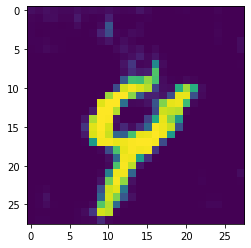

In [37]:
plt.imshow(a[400][:,:,0])